# Python para prototipação em Cripto
Ou: Uma introdução ao SageMath

Thales Paiva \
Cripto 2021 - IME - USP

***

## Pequena nota sobre implementação de Cripto

Implementar Criptografia é muito difícil:
* Não basta mirar em eliminar bugs

Metas são 
* Algoritmos devem rodar em tempo independente dos segredos
* Consumo de energia não pode depender de segredos
* Acesso a memória deve ser uniforme
* Implementação deve ser eficiente ou não será usada

Python parece adequado para implementação criptográfica?

Implementação é quase sempre feita em C (às vezes C++ e hoje em dia em Rust, que é um alívio)

Por que estamos fazendo vocês aprenderem Python então?
Para implementar Cripto:
1. Primeiro prototipamos a especificação em Python
2. Implementamos em C
3. Testamos a implementação em C usando a implementação em Python
4. Fazemos as otimizações e implementação em tempo constante

## Sage

### O que é o Sage?

- Sage é um sistema de computação simbólica 
- Oferece uma interface em Python para Álgebra, Grafos, Análise Numérica, e muito mais
- No Backend, usa sistemas como LAPACK, ATLAS, PARI/GP e M4RI
- Distribuído sob a licença GPLv3


Formalmente ( :
$$
\text{Sage} > \left( \text{Magma} \cup \text{Maple} \cup \text{Mathematica} \cup \text{MATLAB} \right)
$$

Há duas semanas dei uma monitoria básica sobre Sage, que pode ser acessada aqui:
https://drive.google.com/file/d/1Lf7AWQ92n7Scft1OoR_DRT3ufEgt7oLv/view?usp=sharing

O texto auxiliar está aqui:
https://github.com/thalespaiva/monitoria-cripto/blob/master/intro-sage-ep1.ipynb

**Mas o que é computação simbólica?**

Sistemas de computação simbólica permitem trabalhar com expressões matemáticas:

In [1]:
x, y = var('x, y')

In [2]:
f(x, y) = x**2 + sqrt(y)
print(f)

(x, y) |--> x^2 + sqrt(y)


In [3]:

f.derivative()

(x, y) |--> (2*x, 1/2/sqrt(y))

In [4]:
plot3d(f, (x, -1, 1), (y, -1, 1))

Graphics3d Object

**Importante.** Quando queremos respostas numéricas, computação simbólica mais atrapalha do que ajuda.

In [5]:
93/13

93/13

In [6]:
log(1201, 2)

log(1201)/log(2)

Para obtermos a aproximação numérica de uma expressão, usamos a função `n` que toma como parâmetros uma expressão  e, opcionalmente, o número de dígitos da aproximação.

In [7]:
n(93/13)

7.15384615384615

In [8]:
n(log(1201, 2), digits=30)

10.2300204357056340945901830909

In [9]:
numerical_approx(log(1201, 2))

10.2300204357056

### Por que usar Sage?

Vamos comparar código em C e Sage para fazer multiplicações de matrizes binárias.

Em C, a biblioteca mais rápida para fazer multiplicação binária eficiente é chamada M4RI. 

Considere a implementação abaixo:

```C
mzd_t* multiply_two_random_matrices(rci_t n) {
  mzd_t* A = mzd_init(n, n);
  mzd_t* B = mzd_init(n, n);
  mzd_randomize(A);
  mzd_randomize(B);
  mzd_t* C = mzd_mul(NULL, A, B, NULL);
  
  mzd_free(A);
  mzd_free(B);
    
  return C;
}
```

Agora o código em Sage que realiza exatemente a mesma computação:

In [10]:
def multiply_two_random_matrices(n):
    A = random_matrix(GF(2), n, n)
    B = random_matrix(GF(2), n, n)
    return A*B

In [11]:
C = multiply_two_random_matrices(8)
print(C)

[0 1 1 1 0 0 1 1]
[1 0 1 1 1 0 1 0]
[0 1 0 1 0 0 1 1]
[0 0 0 1 0 1 0 1]
[0 1 1 1 0 1 1 1]
[0 1 1 0 0 1 1 1]
[0 0 1 0 0 1 0 1]
[1 0 0 0 0 0 1 0]


As duas implementações rodam em tempo similar **pois Sage chama a rotina da M4RI para fazer a multiplicação!**

Além disso, temos a vantagem de ter a mesma interface para vários sistemas bem diferentes entre si. Por exemplo: podemos usar $\mathbf{C}$ diretamente como matriz de adjacência para construir um grafo

In [12]:
G = sage.graphs.digraph.DiGraph(C)

Podemos obter informações importantes sobre o grafo gerado. Por exemplo, se o grafo é conexo ou não.

In [13]:
G.is_connected()

True

Por onde você começaria a implementar em C isso que acabamos de fazer tão facilmente?


### Como usar o Sage?


O SageMath pode ser usado de 3 formas:
- Usando o Jupyter Notebook (essa é a forma sendo usada neste documento)
- Com um interpretador interativo
- Por meio de scripts


Um dos melhores editores para editar scripts em é o Atom (https://atom.io/), porém qualquer editor de texto pode ser usado.

Para que seu script possa usar todas as funções do sage, ele deve conter `from sage.all import *` no topo.

`script.py`
```python
from sage.all import *

def func1():
    print('Esta é a função 1')

def func2():
    print('Esta é a função 2')

if __name__ == "__main__":
    func1()  # Chama a função 1
    func2()  # Chama a função 2


```

Para rodar o arquivo `script.py`, use:

`sage script.py`

Para a depuração do seu script, é muito útil rodar o script dentro do interpretador interativo do Sage. Da mesma forma que fazemos isso no iPython, podemos rodar `%run script.py` dentro do Sage.

```
/home/user/$ sage
┌────────────────────────────────────────────────────────────────────┐
  SageMath version 9.0, Release Date: 2020-01-01                                  
  Using Python 3.8.2. Type "help()" for help.                                     
└────────────────────────────────────────────────────────────────────┘
sage: %run script.py 
```

## Aritmética modular

Nesta seção, trataremos de $Z_n$, que é o anel de inteiros módulo $n$. 
Primeiro relembremos a definição de Anel.

**Definição.** Um anel $R$ é um conjunto munido de duas operações $+$ (adição) e $.$ (multiplicação), que, para todos $a, b, c \in R$, satisfazem:
1. Associatividade de $+$
$$
(a + b) + c = a + ( b + c)
$$
2. Comutatividade de $+$
$$
a + b = b + a
$$
3. Existência do identidade de $+$. Existe um elemento $0 \in R$ tal que 
    $$
    a + 0 = a
    $$

4. Existência da inversa aditiva. Existe um elemento $(-a) \in R$ tal que 
    $$
    a + (-a) = 0
    $$

5. Associatividade de $.$
$$
(a b) c = a ( b c)
$$
6. Existência da identidade de $.$

    Existe um elemento $1 \in R$ tal que 
    $$ 
    a1 = 1a = a
    $$
7. Distributividade de $.$ sobre $+$:
$$
    (a + b)c = ac + bc \\
    c(a + b) = ca + cb
$$

**Importante**. Note que num anel não é necessário que $.$ seja comutativa, e nem que exista a inversa multiplicativa de todos os elementos.


Em Sage, é muito simples trabalhar com $Z_n$, o anel de inteiros $\bmod n$.

In [14]:
n = 13
Zn = Integers(n)
print(Zn)

Ring of integers modulo 13


In [15]:
Zn.addition_table(names='elements')

 +   0  1  2  3  4  5  6  7  8  9 10 11 12
  +---------------------------------------
 0|  0  1  2  3  4  5  6  7  8  9 10 11 12
 1|  1  2  3  4  5  6  7  8  9 10 11 12  0
 2|  2  3  4  5  6  7  8  9 10 11 12  0  1
 3|  3  4  5  6  7  8  9 10 11 12  0  1  2
 4|  4  5  6  7  8  9 10 11 12  0  1  2  3
 5|  5  6  7  8  9 10 11 12  0  1  2  3  4
 6|  6  7  8  9 10 11 12  0  1  2  3  4  5
 7|  7  8  9 10 11 12  0  1  2  3  4  5  6
 8|  8  9 10 11 12  0  1  2  3  4  5  6  7
 9|  9 10 11 12  0  1  2  3  4  5  6  7  8
10| 10 11 12  0  1  2  3  4  5  6  7  8  9
11| 11 12  0  1  2  3  4  5  6  7  8  9 10
12| 12  0  1  2  3  4  5  6  7  8  9 10 11


In [16]:
Zn.multiplication_table(names='elements')

 *   0  1  2  3  4  5  6  7  8  9 10 11 12
  +---------------------------------------
 0|  0  0  0  0  0  0  0  0  0  0  0  0  0
 1|  0  1  2  3  4  5  6  7  8  9 10 11 12
 2|  0  2  4  6  8 10 12  1  3  5  7  9 11
 3|  0  3  6  9 12  2  5  8 11  1  4  7 10
 4|  0  4  8 12  3  7 11  2  6 10  1  5  9
 5|  0  5 10  2  7 12  4  9  1  6 11  3  8
 6|  0  6 12  5 11  4 10  3  9  2  8  1  7
 7|  0  7  1  8  2  9  3 10  4 11  5 12  6
 8|  0  8  3 11  6  1  9  4 12  7  2 10  5
 9|  0  9  5  1 10  6  2 11  7  3 12  8  4
10|  0 10  7  4  1 11  8  5  2 12  9  6  3
11|  0 11  9  7  5  3  1 12 10  8  6  4  2
12|  0 12 11 10  9  8  7  6  5  4  3  2  1


O Sage cuida para que as operações sejam feitas dentro deste anel.

In [17]:
10 + 9  # Operação fora de Zn

19

In [18]:
(10 + 9) % 13

6

In [19]:
10**20  # Operação fora de Zn

100000000000000000000

In [20]:
10**20 % 13

9

In [21]:
Zn(10) + Zn(9)  # Operação em Zn

6

In [22]:
Zn(10)**20  # Operação em Zn

9

**Comparação de tempo**

In [23]:
import timeit

def power_mod_python(x, e):
    return lambda: x**e % n
def power_mod_Zn(x, e):
    return lambda: Zn(x)**e

N = 100
print(timeit.timeit(power_mod_python(10, 2000000), number=N)/N)
print(timeit.timeit(power_mod_Zn(10, 2000000), number=N)/N)

0.013619533739984035
7.692199869779869e-07


Note que, quando $\gcd(a, n) = 1$, existe inversa de $a \bmod n$, que pode é computada diretamente:

In [24]:
Zn(4)^-1

10

In [25]:
Zn(10)*Zn(4)

1

Além disso, para casos em que precisamos apenas da exponenciação ou inversão modular, sem que seja necessário fazer outras operações em $Z_n$, podemos usar as funções `power_mod` ou `inverse_mod`. Isso evita a sobrecarga de criar o $Z_n$, como fizemos anteriormente.

In [26]:
power_mod(10, 20, 13)

9

In [27]:
inverse_mod(4, 13)

10

Compare as respotas acima com as calculadas sobre elementos de $Z_n$ diretamente.

***

Funções importantes como o Máximo Divisor Comum, Algoritmo de Euclides estendido, e Teorema Chinês do Resto são implementados em Sage.

O MDC (Greatest Common Divisor - GCD) pode ser computado usando a função `gcd`

In [28]:
gcd(133, 48)

1

In [29]:
gcd(12, 18)

6

O algoritmo de Euclides estendido é feito pela função `xgcd`

In [30]:
res, u, v = xgcd(133, 48)

In [31]:
res

1

In [32]:
u*133 + v*48

1

Considere os seguintes resíduos para os quais queremos aplicar o Teorema Chinês do Resto (TCR).
$$
\begin{cases}
    x \equiv 17 \mod 23 \\
    x \equiv 91 \mod 111 \\
    x \equiv 40 \mod 57 \\
\end{cases}
$$

O Teorema Chinês do Resto (Chinese Remainder Theorem - CRT) pode ser usado para encontrar uma solução para as congruências usando a função `crt`

In [33]:
x = crt([17, 91, 40], [23, 111, 57])

In [34]:
x

31504

In [35]:
x % 23, x % 111, x % 57

(17, 91, 40)

## As funções do Sage podem ser usadas para cripto segura?

In [119]:

import timeit

MAX_INT  = 10000
NSAMPLES = 1000

def compare_modular_exponentiation_efficiency(nsamples=NSAMPLES, max_int=MAX_INT):
    
    data = {
        'n': [],
        'p': [],
        'exponent': [],
        'time_power_mod': [],
        'time_regular_exponentiation': []
    }
    
    for _ in range(nsamples):
        n = randint(1, max_int)
        p = random_prime(max_int)
        exponent = randint(1, max_int)

        def compute_with_power_mod():
            v = power_mod(n, exponent, p)

        time_power_mod = timeit.timeit(compute_with_power_mod, number=10)

        def compute_with_regular_exponentiation():
            v = n**exponent % p

        time_regular_exponentiation = timeit.timeit(compute_with_regular_exponentiation, number=10)

        data['n'].append(n)
        data['p'].append(p)
        data['exponent'].append(exponent)
        data['time_power_mod'].append(time_power_mod)
        data['time_regular_exponentiation'].append(time_regular_exponentiation)

        
    return data

data = compare_modular_exponentiation_efficiency()

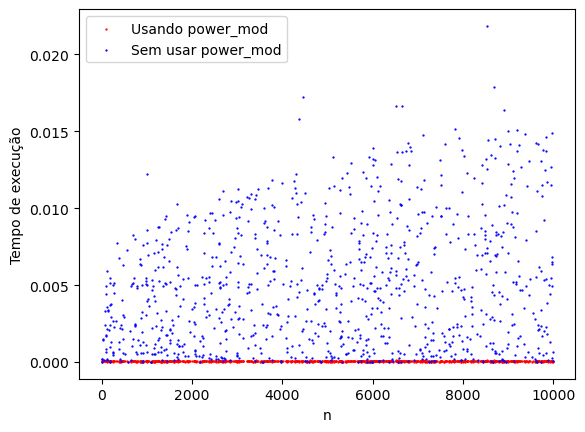

In [120]:
%matplotlib inline


import matplotlib.pyplot as plt

import pandas as pd

df = pd.DataFrame.from_dict(data)

ax = plt.gca()

df.plot.scatter(x='n', y='time_power_mod', label='Usando power_mod', c='red', ax=ax, s=0.4)
df.plot.scatter(x='n', y='time_regular_exponentiation', c='blue', label='Sem usar power_mod', ax=ax, s=0.4)

plt.ylabel('Tempo de execução')
plt.legend()


<AxesSubplot:xlabel='n', ylabel='time_power_mod'>

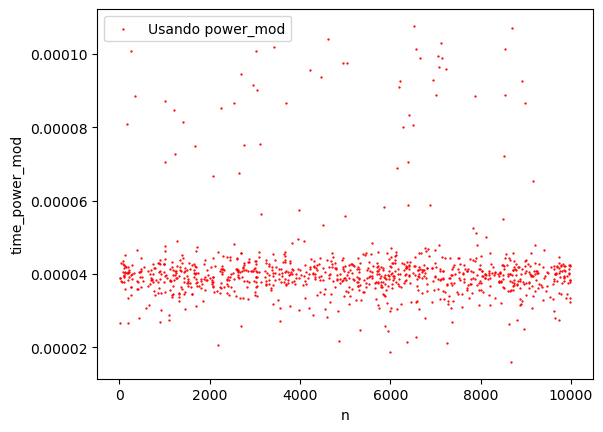

In [121]:
%matplotlib inline
df.plot.scatter(x='n', y='time_power_mod', label='Usando power_mod', c='red', s=0.4)

In [122]:
def hamming_weight(x):
    return bin(x)[2:].count('1')

df['exp_hamming_weight'] = df.exponent.apply(hamming_weight, 1)

In [124]:
bin(59)

'0b111011'

In [123]:
df

,n,p,exponent,time_power_mod,time_regular_exponentiation,exp_hamming_weight
0,3548,4373,59,0.000031,0.000020,5
1,8990,9413,6271,0.000042,0.007070,9
2,8658,5669,4957,0.000044,0.005013,8
3,8098,2029,1511,0.000039,0.000691,8
4,8822,4133,9672,0.000042,0.014070,6
...,...,...,...,...,...,...
995,132,6007,7791,0.000045,0.003294,10
996,8728,2087,7205,0.000042,0.008433,6
997,2186,71,2589,0.000046,0.001361,6
998,273,5483,8388,0.000043,0.005145,4


<AxesSubplot:xlabel='exp_hamming_weight', ylabel='time_power_mod'>

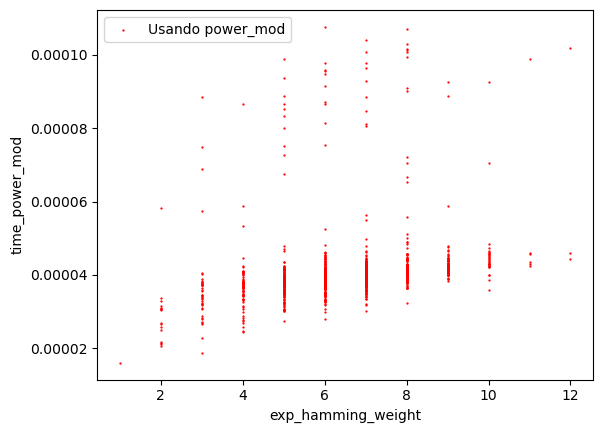

In [126]:
df.plot.scatter(x='exp_hamming_weight', y='time_power_mod', label='Usando power_mod', c='red', s=0.4)

**É possível obter informação parcial sobre o peso de Hamming do expoente pelo tempo de execução do algoritmo!!!**

## Matrizes

Como vimos no começo da aula, Sage é capaz de trabalhar com álgebra de matrizes.

### Criando matrizes e vetores

Para criar uma matriz usando uma lista de listas, usamos a função `matrix`

In [36]:
A = matrix(
    [
        [1, 3, 2],
        [2, 5, 1], 
        [7, 8, 3],
    ]
)
print(A)

[1 3 2]
[2 5 1]
[7 8 3]


Como não foi explicitado a que anel pertencem os elementos de `A`, o Sage supõe que são inteiros. Portanto, ao calcular `A*A`, a resposta é dada em inteiros.

In [37]:
A**10

[ 955297791 1820777299  600591356]
[1021112620 1946219871  641969205]
[2391178115 4557536902 1503323989]

Em criptografia, é muito comum trabalharmos com matrizes de inteiros $\bmod n$. Para isso, podemos fazer a inicialização da seguinte forma.

In [38]:
Zn = Integers(13)  # Apenas para lembrar do que é Zn

An = matrix(Zn,
    [
        [1, 3, 2],
        [2, 5, 1], 
        [7, 8, 3],
    ]
)
print(An)

[1 3 2]
[2 5 1]
[7 8 3]


Agora, o produto `An*An` e soma `An + An` são calculado em `Zn`

In [39]:
An**10

[ 6  3  1]
[ 8 11  7]
[ 1  9 11]

In [40]:
An + An

[ 2  6  4]
[ 4 10  2]
[ 1  3  6]

Muitas vezes, em criptografia, precisamos gerar matrizes aleatórias. Isto pode ser feito usando a função `random_matrix`, que recebe como parâmetro um Anel de base, o número de linhas e o número de colunas.

In [41]:
random_matrix(Zn, 3, 3)

[10  6  1]
[ 8  4 12]
[10  2  2]

### Operações sobre matrizes

O método `inverse` calcula inversa de uma matriz quadrada, quando esta é não singular.

In [42]:
An_inv = An.inverse()
print(An_inv)

[ 3  3 10]
[ 6 12  5]
[ 3  0  7]


In [43]:
An_inv*An

[1 0 0]
[0 1 0]
[0 0 1]

In [44]:
An**(-1)

[ 3  3 10]
[ 6 12  5]
[ 3  0  7]

O determinante pode ser calculado usando o método `determinant`

In [45]:
A.determinant()

-28

O método `echelon_form` devolve a matriz escalonada. Não confunda com o método `echelonize`, que escalona a matriz, alterando-a.

In [46]:
B = random_matrix(Zn, 5, 10)
print('Matriz B')
print(B)
 
print('Matriz B escalonada')
print(B.echelon_form())

Matriz B
[ 4  2 11 12  1  8  2  6  4  0]
[11  6  4  7 10  5  7 10  3  9]
[ 4  8  1  5  9  9  9  9  6  6]
[ 5  5 12  8  3  1  9  0  6  2]
[11  8  4 11  6  1  7  5  4 11]
Matriz B escalonada
[ 1  0  0  0  0  1 11  0 12  3]
[ 0  1  0  0  0 11 11  9 12 10]
[ 0  0  1  0  0  9 12  4  6  2]
[ 0  0  0  1  0 12  4  8  9  8]
[ 0  0  0  0  1 12  3  4  5  6]


Posto e nulidade:

In [47]:
B.rank()

5

In [48]:
B.nullity()

0

### Resolvendo sistemas lineares

Para resolver um sistema da forma $\mathbf{D} \mathbf{x} = \mathbf{b}$, usamos o método `solve_right`.

In [49]:
D = random_matrix(Zn, 4, 4)
b = random_vector(Zn, 4)
print('D = ')
print(D)
print('b = ', b)

D = 
[ 1 10  8 11]
[ 0  3  6  2]
[ 8  7  1  3]
[ 5  7 10 10]
b =  (10, 5, 7, 10)


In [50]:
x = D.solve_right(b)
print(x)

(12, 10, 3, 11)


In [51]:
D*x == b

True

## Corpos

*Definição.* Um Corpo K é um conjunto munido de duas operações $+$ e $.$ tais que:
1. $(K, +, .)$ é um anel
2. A operação $.$ é comutativa. Ou seja, para todos $a, b \in K$:
   $$
   a b = b a, 
   $$
   
3. Para todo elemento $a$ **não nulo** de $K$, existe o seu inverso multiplicativo $a^{-1} \in K$ tal que:
    $$
    aa^{-1} = a^{-1}a = 1
    $$

**Observação**. Corpo é uma abstração do conjunto dos Racionais, onde todos os elementos diferentes de 0 têm inversa.

Em criptografia, tipicamente estamos interessados em corpos finitos, pois os elementos devem ser representados num número finito e prefixado de bits.

**Teorema**. Se $p$ é número primo, então $Z_p$ é um corpo finito.

*Demontração*. Sabemos que $(Z_p, +, .)$ é um anel, então só precisamos mostrar que valem as propriedades 2 e 3. 
Sabemos também que a multiplicação modular é comutativa, o que prova que a propriedade 2 vale.
Além disso, como $p$ é primo, então $\gcd(a, p) = 1$ para todo $a \in Z_p - \{0\}$. Portanto existe a inversa de $a \mod p$, e vale a propriedade 3.


Em sage, para determinar se um determinado anel é também um corpo, podemos usar o método `is_field`

In [52]:
Integers(13).is_field()


True

In [53]:
Integers(10).is_field()

False

Em geral, ao programar, devemos ser o mais explícitos possível. Portanto, ao declarar um conjunto que sabemos que é um corpo, é preferível usar o construtor `GF` (de Galois Field) 

In [54]:
K = GF(13)

Este construtor quebra quando passamos um tamanho incompatível com um corpo finito

In [55]:
try:
    GF(10)
except Exception as e:
    print(e)

the order of a finite field must be a prime power


Há corpos de tamanho não-primo. Em particular o tamanho de um corpo é sempre $q = p^k$ para algum primo $p$ e algum inteiro positivo $k \geq 1$.

Porém, pelo modo como é feita a multiplicação em corpos finitos de tamanhos não primos, seus elementos são melhor representados por polinômios e não por inteiros.

In [56]:
GF(7**2, 't').random_element()

3*t + 5

In [57]:
Integers(7**2).is_field()

False

In [58]:
GF(7**2).random_element()

z2 + 6

In [59]:
GF(7).random_element()

4

Para entender como chegar nisso, primeiro vejamos como construir anéis polinômiais.

## Anéis Polinomiais

Um anel polinomial $K[x]$ nada mais é que o conjunto de polinômios em $x$ com coeficientes em $K$. Tipicamente, estamos interessados em $K$ sendo um corpo, mas a construção vale para $K$ sendo apenas um anel.
Para ver que $K[x]$ é um anel, basta usar o fato de que $K$ é um corpo (e portanto um anel) e usar as regras de adição e multiplicações de polinômios.

Para criar um anel polinomial `R` sobre a variavel `x` e com coeficientes em `GF(13)`, em Sage, fazemos:

In [60]:
R.<x> = GF(13)[]

In [61]:
R

Univariate Polynomial Ring in x over Finite Field of size 13

In [62]:
R2 = GF(13).polynomial_ring('x2')

In [63]:
R2

Univariate Polynomial Ring in x2 over Finite Field of size 13

In [64]:
v = R.random_element(4)  # 10 é o grau do elemento aleatório
print(v)

5*x^4 + x^3 + 5*x^2 + 7*x + 9


Note que $GF(n)[x]$ é infinito.

In [65]:
R.cardinality()

+Infinity

Para contruir um anel polinomial finito, podemos fazer o análogo do que fizemos para construir $Z_n$ a partir de $Z$: pegar os resíduos quando dividimos por um elemento $p_1 \in R$. O anel construído é denotado por $R/p_1$

In [66]:
p1 = x^2 + x
R_mod_p1 = R.quotient(p1)

Note que o número de resíduos quando dividimos por um polinômio de grau 2 é dado por
$$
( \text{possibilidades para coeficiente de grau 0}) \times (\text{possibilidades para coeficiente de grau 1}) = n^2
$$

In [67]:
R_mod_p1.cardinality()

169

Porém note que o anel quociente construído não é um corpo:

In [68]:
R_mod_p1.is_field()

False

O motivo por que $R/p_1$ não é um corpo é análogo ao motivo de $Z_{10}$ não ser um corpo: o módulo não é primo, e há elementos $a$ em $R/p_1$ tais que $\gcd(a, p_1) \neq 1$

In [69]:
gcd(x + 1, x^2 + x)

x + 1

**Definição**. Um polinômio $m \in GF(q)[x]$ é primo (ou irredutível) quando ele **não** pode ser fatorado em dois polinômios não-constantes de $GF(q)[x]$.

No caso anterior, $p_1= x^2 + x$ claramente pode ser fatorado em $x(x + 1)$.

**Observação**. Para mostrar que um polinômio não é primo, basta mostrar uma fatoração. Agora, para mostrar que um polinômio é primo não é tão fácil...

Por sorte, o Sage vem com um método que devolve um polinômio irredutível num anel polinomial, dado um grau.

In [70]:
m = R.irreducible_element(2)
print(m)

x^2 + 12*x + 2


Podemos agora fazer a mesma construção anterior só que com $m$ irredutível no lugar de $p_1$.

In [71]:
R_mod_m = R.quotient(m)

Neste caso, $R/m$ será um corpo finito de $13^2 = 169$ elementos.

In [72]:
R_mod_m.is_field()

True

In [73]:
R_mod_m.cardinality()

169

Note que $R/m$ e $R/p_1$ contam com exatamente os mesmos polinômios! A diferença ocorre na multiplicação de elementos, que, quando feita $\bmod m$, mantém a propriedade da existência do inverso.

**Importante**. Se tomarmos outro polinômio irredutível $m_2$ do mesmo grau de $m$, os corpos finitos $R/m$ e $R/m_2$ são isomórficos. Há um teorema importante que diz que todos os corpos finitos de mesmos tamanhos são isomórficos.

Para ver isso na prática, considere.

In [74]:
P.<t1> = GF(2)[]

In [75]:
m1 = P.irreducible_element(3, algorithm='random')
m2 = P.irreducible_element(3, algorithm='random')
print("Queremos m1 != m2")
print(m1)
print(m2)

Queremos m1 != m2
t1^3 + t1 + 1
t1^3 + t1 + 1


In [76]:
P.quotient(m1, 'i').multiplication_table()

*  a b c d e f g h
 +----------------
a| a a a a a a a a
b| a b c d e f g h
c| a c e g d b h f
d| a d g f h e b c
e| a e d h g c f b
f| a f b e c h d g
g| a g h b f d c e
h| a h f c b g e d


In [77]:
P.quotient(m2, 'j').multiplication_table()

*  a b c d e f g h
 +----------------
a| a a a a a a a a
b| a b c d e f g h
c| a c e g d b h f
d| a d g f h e b c
e| a e d h g c f b
f| a f b e c h d g
g| a g h b f d c e
h| a h f c b g e d


**Observação**. É possível achar uma bijeção entre os polinômios dos dois corpos que transforma uma tabela na outra. (Não que seja uma coisa muito fácil de fazer agora, mas acho que a ideia do isomorfismo fica bem ilustrada pelas tabelas.)

## O Corpo finito $GF(2^m)$

Vimos que todos os corpos finitos são isomórficos a $GF(p^k)$ para algum primo $p$ e algum inteiro $k \geq 1$. Vimos também que para usar qualquer um desses corpos finitos em Sage, usamos o construtor `GF`, **não** sendo necessário criar anéis polinomiais e selecionar um polinômio irredutível.

Em criptografia é comum usarmos corpos finitos de característica 2, isto é, $p = 2$, pois algumas operações podem ser simplificadas usando operações de bits.

Uma aplicação interessante é que podemos definir uma operação de multiplicação sobre bytes.

Considere por exemplo o $GF(2^8)$ na representação usada pelo AES.

In [78]:
t = GF(2).polynomial_ring().gen()
F8 = GF(2^8, 't', modulus=t^8 + t^4 + t^3 + t + 1)
F8

Finite Field in t of size 2^8

In [79]:
b1 = F8.random_element()
b2 = F8.random_element()
print(b1)
print(b2)

t^7 + t^6 + t^5 + t
t^6 + t^3 + t^2 + t + 1


In [80]:
F8.cardinality()

256

Para obter a representação de `b1` e `b2` como sequências de bits, podemos fazer:

In [81]:
list(b1.polynomial())

[0, 1, 0, 0, 0, 1, 1, 1]

In [82]:
b1

t^7 + t^6 + t^5 + t

In [83]:
print(list(b1.polynomial()))
print(list(b2.polynomial()))

[0, 1, 0, 0, 0, 1, 1, 1]
[1, 1, 1, 1, 0, 0, 1]


Note como a soma de `b1` e `b2` é simplesmente o XOR bit a bit 

In [84]:
print(list((b1 + b2).polynomial()))

[1, 0, 1, 1, 0, 1, 0, 1]


E agora temos uma definição para o produto de dois bytes `b1*b2`

In [85]:
b1*b2

t^6 + t^5 + t^4 + t^2 + t + 1

In [86]:
print(list((b1*b2).polynomial()))

[1, 1, 1, 0, 1, 1, 1]


In [87]:
b1.integer_representation()*b2.integer_representation() % 256

190

In [88]:
(b1*b2).integer_representation()

119

Para pegar a representação em bytes de um elemento de `F8`, basta usarmos o método `integer_representation`

In [89]:
n1 = b1.integer_representation()
print(n1)

226


In [90]:
bin(10)

'0b1010'

Para o processo inverso, não há uma função pronta. Podemos usar a função `bin` para implementar a conversão de inteiros para elementos de `F8`

In [91]:
def int_to_F8_poly(n):
    t = F8.gen()
    if not (0 <= n < 2**8):
        raise ValueError('Deve-se obedecer à condição 0 <= int1, int2 < 256')
    coeffs = reversed(bin(n)[2:])
    return sum(GF(2)(v)*(t**i) for i, v in enumerate(coeffs))

In [92]:
int_to_F8_poly(23)

t^4 + t^2 + t + 1

In [93]:
bin(23)

'0b10111'

Teste de sanidade:

In [94]:
int_to_F8_poly(b1.integer_representation()) == b1

True

Para explicitar as operações que queremos implementar, podemos usar as seguintes funções `bytes_sum` e `bytes_product`:

In [95]:
def bytes_sum(n1, n2):
    '''
        n1: Inteiro >= 0 e < 256
        n2: Inteiro >= 0 e < 256
    '''
    b1 = int_to_F8_poly(n1)
    b2 = int_to_F8_poly(n2)
    
    return (b1 + b2).integer_representation()

def bytes_product(n1, n2):
    '''
        n1: Inteiro >= 0 e < 256
        n2: Inteiro >= 0 e < 256
    '''
    b1 = int_to_F8_poly(n1)
    b2 = int_to_F8_poly(n2)
    
    return (b1 * b2).integer_representation()



In [96]:
hex(bytes_product(int('53', 16), int('ca', 16)))  # Deve dar 0x01

'0x1'

In [97]:
hex(bytes_product(int('45', 16), int('02', 16)))  # Deve dar 0x8a

'0x8a'

In [98]:
hex(bytes_product(int('c5', 16), int('02', 16)))  # Deve dar 0x91

'0x91'

**Importante**. Este modo de implementar a soma e o produto não é o mais eficiente. Em geral, as operações são implementadas usando operações de bits, que são muito mais rápidas.